<a href="https://colab.research.google.com/github/Henil21/Natural_Language_processing/blob/main/LSTM_BI_GRU_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import LabelEncoder

In [3]:
data=pd.read_csv('/content/train.csv')

In [4]:
# data=pd.read_csv('/content/en_dataset_with_stop_words.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
train_sentences,val_sentences,train_labels,val_labels=train_test_split(data["text"].to_numpy(),
                                                                       data["target"].to_numpy(),
                                                                       test_size=0.3,
                                                                       random_state=42)
print(train_sentences[0])
print(train_labels[0])

Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
0


In [14]:
# len(train_sentences)
data["target"].unique()

#class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

array([1, 0])

In [15]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [23]:
# from tensorflow.keras.layers.preprocessing import TextVectorization

# Setup text vectorization with custom variables
max_vocab_length = 1000 # max number of words to have in our vocabulary
max_length = 20 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                    standardize="lower_and_strip_punctuation",
                                     split="whitespace",
                                    output_mode="int",
                                    output_sequence_length=max_length)
text_vectorizer.adapt(train_sentences)


In [24]:
max_vocab_length = 1000 # max number of words to have in our vocabulary
max_length = 20
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length,#set the input shape
                             output_dim=128,
                             input_length=max_length)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
# Convert text into number
from sklearn.feature_extraction.text import TfidfVectorizer
# our model
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

# create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()),# convert words to number using tfidf
    ("clf",MultinomialNB())# model the text
])
# fit the pipleine to the training data
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
baseline_score=model_0.score(val_sentences,val_labels)
# as we use .evaluate in tf for sklearn its .score
baseline_score*100

80.69176882661996

In [ ]:
# import tensorflow_hub as hub
# embed=hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
# sentence_encoder_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
#                                                                     input_shape=(),
#                                                                     dtype=tf.string,
#                                                                     trainable=False,
#                                                                     name="USE"
#                                                                     )

In [27]:
tf.random.set_seed(42)
from tensorflow.keras.optimizers import RMSprop

input=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(input)
x=embedding(x)
x=layers.LSTM(64,return_sequences=True)(x)

x=layers.Bidirectional(layers.GRU(64))(x)
x=layers.Dropout(0.5)(x)


outputs=layers.Dense(3,activation='softmax')(x)
model_4=tf.keras.Model(input,outputs,name="model_4_bidirectional")

In [28]:
# Compile model
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [29]:
# Fit the model
model_4_history=model_4.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels))

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5876 - loss: 0.7467 - val_accuracy: 0.7719 - val_loss: 0.4849
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7930 - loss: 0.4520 - val_accuracy: 0.7806 - val_loss: 0.4768
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8222 - loss: 0.4084 - val_accuracy: 0.7859 - val_loss: 0.4651
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8290 - loss: 0.3911 - val_accuracy: 0.7868 - val_loss: 0.4897
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8346 - loss: 0.3729 - val_accuracy: 0.7846 - val_loss: 0.5233


In [30]:

import pandas as pd
def plot_loss_curves(hist):
    pd.DataFrame(hist.history).plot(figsize=(5,5))

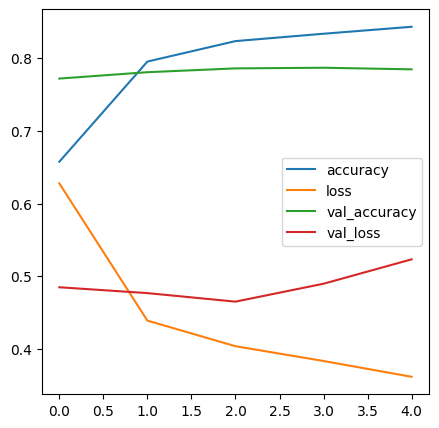

In [31]:
plot_loss_curves(model_4_history)

In [32]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calculate_results(y_true,y_pred):
  # Calculate model accuracy
  model_accuracy=accuracy_score(y_true,y_pred)*100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision":model_precision*100,
                   "recall":model_recall*100,
                   "f1":model_f1*100
                   }
  return model_results

In [33]:
y_pred=model_4.predict(val_sentences)
y_pred[:10]

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


array([[9.59049225e-01, 4.09442373e-02, 6.56013253e-06],
       [9.42109168e-01, 5.75202554e-02, 3.70638882e-04],
       [2.10735708e-01, 7.89108694e-01, 1.55596383e-04],
       [7.95920730e-01, 2.03453898e-01, 6.25318324e-04],
       [1.98203251e-01, 8.01658869e-01, 1.37928146e-04],
       [8.98261845e-01, 1.01441026e-01, 2.97112303e-04],
       [7.02207983e-01, 2.96886683e-01, 9.05331573e-04],
       [8.60520959e-01, 1.38264835e-01, 1.21415872e-03],
       [7.90279627e-01, 2.09690094e-01, 3.03349971e-05],
       [1.17898457e-01, 8.82067561e-01, 3.39659855e-05]], dtype=float32)

In [34]:
predicted_class_indices = np.argmax(y_pred, axis=1)
print(predicted_class_indices[:20])
print(val_labels[:20])

[0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0]
[1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0]


In [35]:
calculate_results(val_labels,predicted_class_indices)

{'accuracy': 78.45884413309983,
 'precision': 78.40379632529861,
 'recall': 78.45884413309983,
 'f1': 78.42393211594074}